# Waste Management Classification 

## Goal 
This project aims to classify images into organic and recyclable categories.  Given the prevalence of global warming and environmental negligence in the various news outlets worldwide, I have concerned myself with a subset of such things, waste management.  The aforementioned model will permit for automating a subset of the waste management process.

### Disclaimer: To run this notebook, you will probably need to utilize cloud services.

## Import Necessary Libraries

In [11]:
from keras.applications import VGG19, inception_v3
from keras import models, layers, optimizers, regularizers
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Importing the Data and Preprocessing 

[Data Source](https://www.kaggle.com/techsash/waste-classification-data): contains images that are broadly labeled as organic or recyclable

Images were brought in, scaled, set to a standard 224 by 224 size.  Given that the total dataset was prohibitive in terms of computation, the initial samples were of size 2000 from the test folder and 4000 from the train folder.  Additional images were generated that were manipulated to make the model more robust, e.g., rotating, zooming, and flipping the original images.  These provided an additional 3000 images.

In [6]:
data_te = ImageDataGenerator(rescale = 1./255).flow_from_directory('DATASET_2/TEST', 
                                                                   target_size = (224, 224), 
                                                                   batch_size = 2000,
                                                                   seed = 123)

data_tr = ImageDataGenerator(rescale = 1./255).flow_from_directory('DATASET_2/TRAIN', 
                                                                   target_size = (224, 224),  
                                                                   batch_size = 4000,
                                                                   seed = 123)

Found 2513 images belonging to 2 classes.
Found 22564 images belonging to 2 classes.


In [7]:
mod_te = ImageDataGenerator(rescale = 1./255, 
                            rotation_range = 360, 
                            width_shift_range = 0.3, 
                            height_shift_range = 0.3, 
                            brightness_range = [0.2, 1.0], 
                            horizontal_flip = True, 
                            vertical_flip = True, 
                            zoom_range = [0.5, 1.5]).flow_from_directory('DATASET_2/TEST', 
                                                                   target_size = (224, 224), 
                                                                   batch_size = 1000,
                                                                   seed = 123)

mod_tr = ImageDataGenerator(rescale = 1./255, 
                            rotation_range = 360, 
                            width_shift_range = 0.3, 
                            height_shift_range = 0.3, 
                            brightness_range = [0.2, 1.0], 
                            horizontal_flip = True, 
                            vertical_flip = True, 
                            zoom_range = [0.5, 1.5]).flow_from_directory('DATASET_2/TRAIN', 
                                                                   target_size = (224, 224), 
                                                                   batch_size = 2000,
                                                                   seed = 123)

Found 2513 images belonging to 2 classes.
Found 22564 images belonging to 2 classes.


Here, I extracted the processed images and their associated labels and checked their dimensionality.

In [8]:
images_te, labels_te = next(data_te)
images_tr, labels_tr = next(data_tr)

In [9]:
images_mod_te, labels_mod_te = next(mod_te)
images_mod_tr, labels_mod_tr = next(mod_tr)

In [32]:
print(images_te.shape)
print(images_tr.shape)

(2000, 224, 224, 3)
(4000, 224, 224, 3)


In [33]:
print(images_mod_te.shape)
print(images_mod_tr.shape)

(1000, 224, 224, 3)
(2000, 224, 224, 3)


In [34]:
print(labels_te.shape)
print(labels_tr.shape)

(2000, 2)
(4000, 2)


In [35]:
print(labels_mod_te.shape)
print(labels_mod_tr.shape)

(1000, 2)
(2000, 2)


The images were pulled from disparate folders, so I needed to merge the data which was accomplished as follows.

In [10]:
images = np.concatenate((images_tr, images_te, images_mod_tr, images_mod_te))
# images = np.concatenate((images_mod_tr, images_mod_te))

In [37]:
images.shape

(9000, 224, 224, 3)

In [11]:
labels = np.concatenate((labels_tr[:,0], labels_te[:,0], labels_mod_tr[:,0], labels_mod_te[:, 0]))
# labels = np.concatenate((labels_mod_tr[:,0], labels_mod_te[:, 0]))

In [39]:
labels.shape

(9000,)

General inspection of the images was accomplished in the following cell.  The integers can be changed to have an idea of the types of images.  Their associated labels are printed below the image.  A label of zero is recyclable, and a label of one is organic.

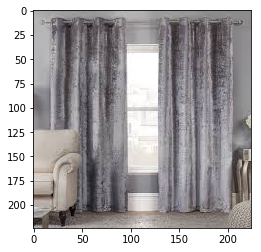

0.0


In [39]:
plt.imshow(images[5510])
plt.show()
print(labels[5510])

For modeling, I split the data into train, validation, and test sets.

In [12]:
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 123)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size = 0.2, random_state = 123)

I check the sample size of each of the splits, e.g., the training set is 5760.

In [11]:
print(len(X_train), '\n')
print(len(X_val), '\n')
print(len(X_test), '\n')

5760 

1440 

1800 



In classification, the balance of the classes is of particular importance, so a quick inspection was done.  For each of the split samples, the data are well-balanced with the organic class making up a little over half in all cases.

In [12]:
print(sum(y_train)/5760)
print(sum(y_val)/1440)
print(sum(y_test)/1800)

0.5446180555555555
0.5611111111111111
0.5538888888888889


## Building CNN Models 

Prebuilt convolutional layers were utilized from the keras library, namely VGG19 and InceptionV3.  The convolutional layers of these models were frozen so they wouldn't be affected by the training process.  This was desirable given that their models had been trained on gargantuan datasets.  Their specifications were as follows:

-loss function: binary cross entropy  
-optimizer: adaptive moment estimation  
-performance metric: accuracy (depending on the waste processing, the desired performance metric may differ)
-number of (dense) hidden layers: 3 (with 1024, 1024, and 512 nodes, respectively)  
-regularization: dropout (with 0.2 probability)
-hidden layer activation functions: rectified linear unit  
-weights initialization: Xavier  
-output layer activation function: sigmoid

### VGG19 

In [13]:
cnn_vgg_base = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
model_1 = models.Sequential()
model_1.add(cnn_vgg_base)
model_1.add(layers.Flatten())
model_1.add(layers.Dense(1024, activation='relu', kernel_initializer = 'glorot_uniform'))
model_1.add(layers.Dropout(0.2, seed = 123))
model_1.add(layers.Dense(1024, activation='relu', kernel_initializer = 'glorot_uniform'))
model_1.add(layers.Dropout(0.2, seed = 123))
model_1.add(layers.Dense(512, activation='relu', kernel_initializer = 'glorot_uniform'))
model_1.add(layers.Dropout(0.2, seed = 123))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [14]:
for layer in model_1.layers:
    print(layer.name, layer.trainable)

vgg19 True
flatten_1 True
dense_1 True
dropout_1 True
dense_2 True
dropout_2 True
dense_3 True
dropout_3 True
dense_4 True


In [15]:
cnn_vgg_base.trainable = False

I rerun the layers.trainable to make sure that the prebuilt convolutional base is not trainable.

In [16]:
for layer in model_1.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_1 True
dense_1 True
dropout_1 True
dense_2 True
dropout_2 True
dense_3 True
dropout_3 True
dense_4 True


In [17]:
model_1.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(), metrics = ['acc'])

In [19]:
model_1.fit(X_train, 
            y_train, 
            batch_size = 96, 
            epochs = 15, 
            validation_data = (X_val, y_val) )

Train on 5760 samples, validate on 1440 samples
Epoch 1/15
5760/5760 [==============================] - 1085s 188ms/step - loss: 0.2277 - acc: 0.9016 - val_loss: 0.3418 - val_acc: 0.8618
Epoch 2/15
5760/5760 [==============================] - 1079s 187ms/step - loss: 0.1713 - acc: 0.9293 - val_loss: 0.4009 - val_acc: 0.8535
Epoch 3/15
5760/5760 [==============================] - 1077s 187ms/step - loss: 0.1451 - acc: 0.9394 - val_loss: 0.4932 - val_acc: 0.8493
Epoch 4/15
5760/5760 [==============================] - 1078s 187ms/step - loss: 0.1533 - acc: 0.9351 - val_loss: 0.4828 - val_acc: 0.8590
Epoch 5/15
5760/5760 [==============================] - 1077s 187ms/step - loss: 0.0946 - acc: 0.9623 - val_loss: 0.4490 - val_acc: 0.8590
Epoch 6/15
5760/5760 [==============================] - 1079s 187ms/step - loss: 0.1037 - acc: 0.9563 - val_loss: 0.6065 - val_acc: 0.8611
Epoch 7/15
5760/5760 [==============================] - 1082s 188ms/step - loss: 0.0787 - acc: 0.9658 - val_loss: 0.65

In [20]:
model_1.save('vgg19.h5')
# models.load_model('vgg19.h5')

In [21]:
model_1.evaluate(X_test, y_test)

1800/1800 [==============================] - 283s 157ms/step


[0.6911880603763793, 0.875]

In [22]:
# mod_1_pred = np.around(model_1.predict(X_test))
mod_1_test_pred = model_1.predict_classes(X_test)

In [23]:
print(confusion_matrix(y_test, mod_1_test_pred))
print(classification_report(y_test, mod_1_test_pred))

[[713  90]
 [135 862]]
             precision    recall  f1-score   support

        0.0       0.84      0.89      0.86       803
        1.0       0.91      0.86      0.88       997

avg / total       0.88      0.88      0.88      1800



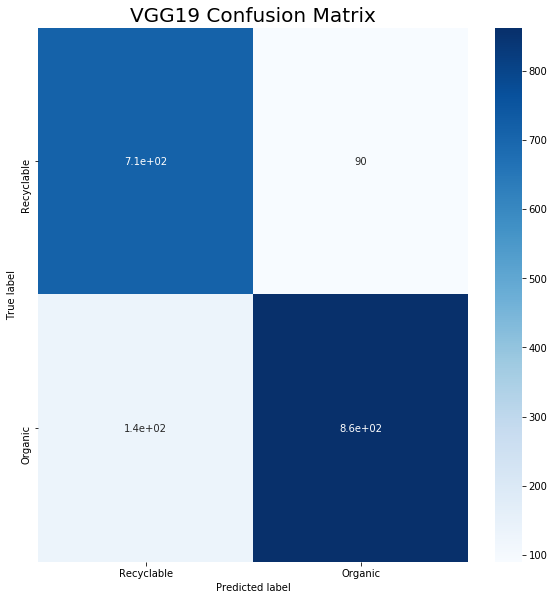

<Figure size 432x288 with 0 Axes>

In [41]:
# yellowbrick doesn't work with keras; change class labels
con_mat_1 = tf.math.confusion_matrix(labels=y_test, predictions=mod_1_test_pred).numpy()
con_mat_1_df = pd.DataFrame(con_mat_1,
                     index = ['Recyclable', 'Organic'], 
                     columns = ['Recyclable', 'Organic'])

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_1_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('VGG19 Confusion Matrix', fontsize = 20)
plt.show()
plt.savefig('vgg19_conf_mat.png')

### InceptionV3 

In [2]:
cnn_incv3_base = inception_v3.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
model_2 = models.Sequential()
model_2.add(cnn_incv3_base)
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.2, seed = 123))
model_2.add(layers.Dense(1024, activation='relu', kernel_initializer = 'glorot_uniform'))
model_2.add(layers.Dropout(0.2, seed = 123))
model_2.add(layers.Dense(512, activation='relu', kernel_initializer = 'glorot_uniform'))
model_2.add(layers.Dropout(0.2, seed = 123))
model_2.add(layers.Dense(1, activation='sigmoid'))

87916544/87910968 [==============================] - 2s 0us/step


In [3]:
cnn_incv3_base.trainable = False

In [4]:
model_2.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(), metrics = ['acc'])

In [14]:
model_2.fit(X_train, 
            y_train, 
            batch_size = 96, 
            epochs = 15, 
            validation_data = (X_val, y_val) )

Train on 5760 samples, validate on 1440 samples
Epoch 1/15
5760/5760 [==============================] - 543s 94ms/step - loss: 1.5980 - acc: 0.7358 - val_loss: 0.2844 - val_acc: 0.8882
Epoch 2/15
5760/5760 [==============================] - 512s 89ms/step - loss: 0.3066 - acc: 0.8795 - val_loss: 0.4284 - val_acc: 0.8590
Epoch 3/15
5760/5760 [==============================] - 521s 90ms/step - loss: 0.2356 - acc: 0.9080 - val_loss: 0.3042 - val_acc: 0.8924
Epoch 4/15
5760/5760 [==============================] - 515s 89ms/step - loss: 0.1845 - acc: 0.9278 - val_loss: 0.3076 - val_acc: 0.9035
Epoch 5/15
5760/5760 [==============================] - 513s 89ms/step - loss: 0.1462 - acc: 0.9405 - val_loss: 0.3876 - val_acc: 0.9118
Epoch 6/15
5760/5760 [==============================] - 511s 89ms/step - loss: 0.1529 - acc: 0.9415 - val_loss: 0.3415 - val_acc: 0.8951
Epoch 7/15
5760/5760 [==============================] - 513s 89ms/step - loss: 0.1063 - acc: 0.9608 - val_loss: 0.4692 - val_acc: 

In [15]:
model_2.save('incv3.h5')
# models.load_model('incv3.h5')

In [16]:
model_2.evaluate(X_test, y_test)

1800/1800 [==============================] - 143s 80ms/step


[0.9880882908238305, 0.847777783870697]

In [18]:
# mod_2_pred = np.around(model_2.predict(X_test))
mod_2_test_pred = model_2.predict_classes(X_test)

In [21]:
print(confusion_matrix(y_test, mod_2_test_pred))
print(classification_report(y_test, mod_2_test_pred))

[[548 255]
 [ 19 978]]
             precision    recall  f1-score   support

        0.0       0.97      0.68      0.80       803
        1.0       0.79      0.98      0.88       997

avg / total       0.87      0.85      0.84      1800



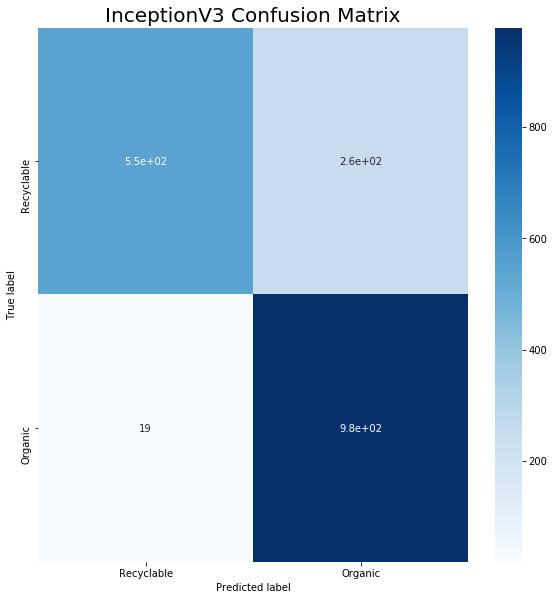

<Figure size 432x288 with 0 Axes>

In [22]:
con_mat_2 = tf.math.confusion_matrix(labels=y_test, predictions=mod_2_test_pred).numpy()
con_mat_2_df = pd.DataFrame(con_mat_2,
                     index = ['Recyclable', 'Organic'], 
                     columns = ['Recyclable', 'Organic'])

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_2_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('InceptionV3 Confusion Matrix', fontsize = 20)
plt.show()
plt.savefig('incv3_conf_mat.png')

## Findings and Future Work
The VGG19 based model performed best on the test set of data with an accuracy of 87.5 percent -- a testament to the feasibility of employing such methods for the purposes set forth in the goal statement.  Better models could be built by tuning the hyperparameters and using a larger sample.

## Appendix: Saving Architecture and Weights

The following code can be run in order to store the models.  The json files store the architecture.  The full model and weights were too large to store on GitHub.

### VGG19 Model

In [8]:
vgg19 = models.load_model('vgg19.h5')
vgg19_json = vgg19.to_json()
vgg19.save_weights('vgg19_weights.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [9]:
with open("vgg19.json", "w") as json_file:
    json_file.write(vgg19_json)

In [12]:
# load json and create model
json_file = open('vgg19.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("vgg19_weights.h5")

### InceptionV3 Model

In [16]:
incv3 = models.load_model('incv3.h5')
incv3_json = incv3.to_json()
incv3.save_weights('incv3_weights.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [17]:
with open("incv3.json", "w") as json_file:
    json_file.write(incv3_json)

In [18]:
# load json and create model
json_file = open('incv3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("incv3_weights.h5")